# HomeWork 9

**DeadLine : 23:59 5 Azar 1399**

**Total points : 100 pts**

Import some prerequisites.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 2

Here is for your helper functions (optional).

Implement this function for Augmented reality.

In [3]:
def AR(background, image):
    '''
    Adds the input image to the background image properly.
    
    Parameters:
        background (numpy.ndarray) : background image
        image (numpy.ndarray): input image
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    out_img = background.copy()

    #Write your code here
    
    rowsf, colsf, blah = image.shape
    
    from_points = np.array([[0, 0], [colsf - 1, 0], [0, rowsf - 1], [colsf - 1, rowsf - 1]])

    to_points = np.array([[151, 108], [233, 108], [146, 223], [234, 225]]) #THIS IS PERFECT

    M, _ = cv2.findHomography(from_points, to_points)

    transformed_flower = cv2.warpPerspective(image, M, (out_img.shape[1], out_img.shape[0]), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT,)
    
    rows, cols, blah = background.shape

    for row in range(0, rows):
      for col in range(0, cols):
        if np.any(transformed_flower[row, col] != 0):
          out_img[row, col] = transformed_flower[row, col]

    
    
    return out_img

Test your implementation (dont change this cell)

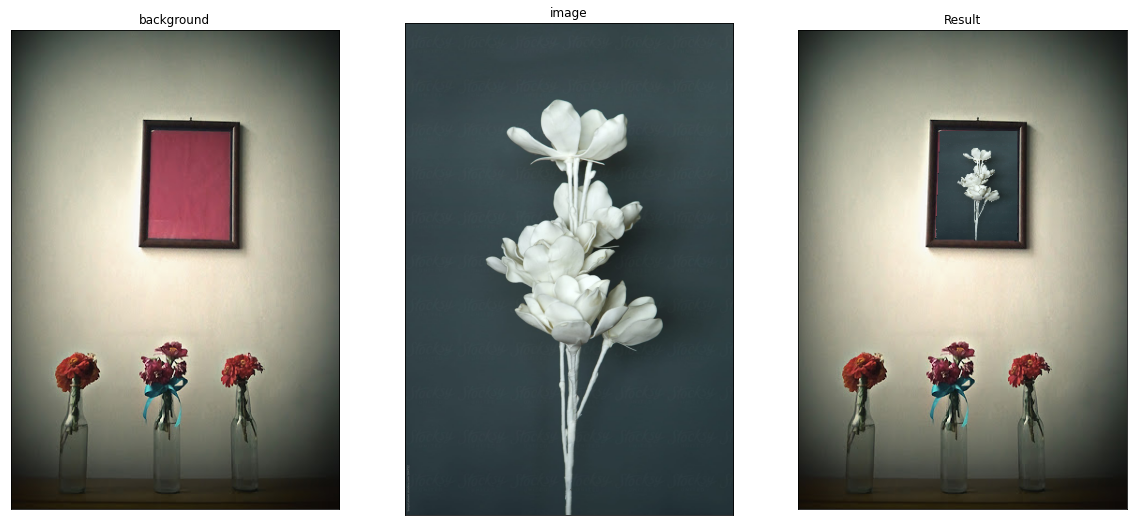

In [4]:
image_list = []

background = cv2.imread(os.path.join('images', 'background.jpg'))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
image_list.append([background, 'background', 'img'])

image = cv2.imread(os.path.join('images', '1.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_list.append([image, 'image', 'img'])

image_list.append([AR(background, image), 'Result', 'img'])


plotter(image_list,1 , 3, True, 20, 10, '2')

# PART 3A

Here is for your helper functions (optional).

Implement this function to get the global otsu algorithm output.

In [5]:
def global_otsu(image):
    '''
    Applys global otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    out_img = image.copy()
    
    #Write your code here
    
#     https://en.wikipedia.org/wiki/Otsu%27s_method
    
    histogram = np.zeros((256), np.int)
    rows,cols = image.shape
    for row in range(0, rows):
        for col in range(0, cols):
            histogram[image[row, col]] += 1
            
    
    threshold = -1
    max_res = -100
    indexes = []
    for i in range(0, 256):
        indexes.append(i)
    normalizer = 1/(rows * cols)
    
    for t in range(1, 255):
        w1 = np.sum(histogram[:t])
        w2 = np.sum(histogram[t:])

        miu1 = np.sum(indexes[:t]*histogram[:t]) / w1
        miu2 = np.sum(indexes[t:]*histogram[t:]) / w2

        res = w1 * normalizer * w2 * normalizer * (miu1 - miu2) ** 2

        if res > max_res:
            max_res = res
            threshold = t


    for row in range(0, rows):
        for col in range(0, cols):
            if out_img[row, col] >= threshold:
                out_img[row, col] = 255
            else:
                out_img[row, col] = 0
                   
    return out_img

Test your implementation (dont change this cell)

<ipython-input-5-95effa0f5ff2>:37: RuntimeWarning: invalid value encountered in long_scalars
  miu2 = np.sum(indexes[t:]*histogram[t:]) / w2


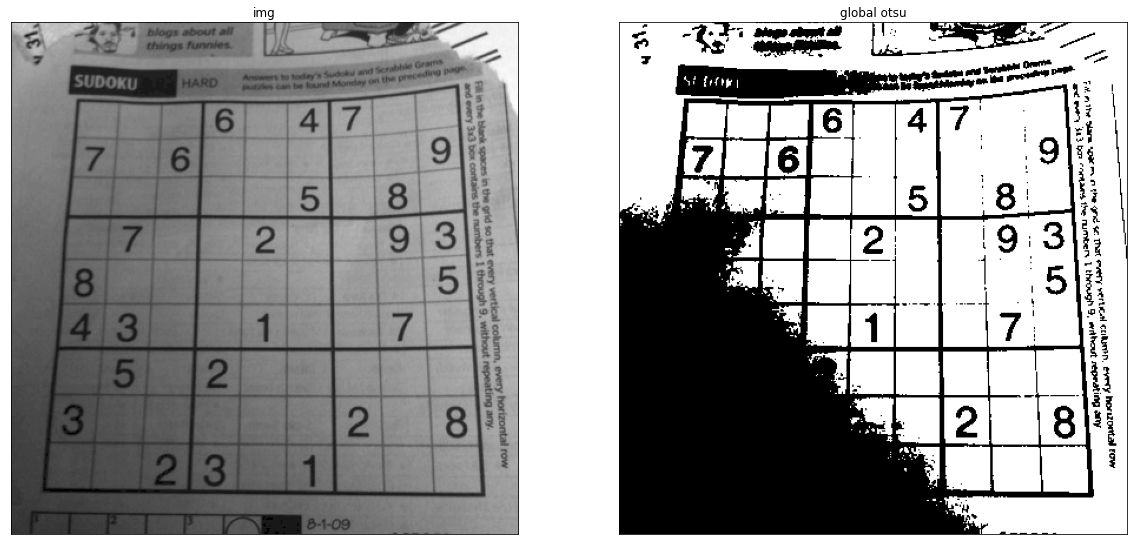

In [6]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])



image_list.append([global_otsu(image), 'global otsu', 'img'])

plotter(image_list, 1, 2, True, 20, 10, '3A')

# PART 3B

Here is for your helper functions (optional).

Implement this function to get local otsu algorithm output.

In [7]:
def local_otsu(image):
    '''
    Applys local otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    out_img = image.copy()
    
    #Write your code here
    rows, cols = image.shape

    one = global_otsu(image[0:int(rows/2), 0:int(cols/2)])
    two = global_otsu(image[0:int(rows/2), int(cols/2):cols-1])
    three = global_otsu(image[int(rows/2):rows-1, 0:int(cols/2)])
    four = global_otsu(image[int(rows/2):rows-1, int(cols/2):cols-1])
    
    onetwo = np.concatenate((one, two), axis=1)
    threefour = np.concatenate((three, four), axis=1)
    out_img = np.concatenate((onetwo, threefour), axis=0)
    
    return out_img

Test your implementation (dont change this cell)

<ipython-input-5-95effa0f5ff2>:37: RuntimeWarning: invalid value encountered in long_scalars
  miu2 = np.sum(indexes[t:]*histogram[t:]) / w2
<ipython-input-5-95effa0f5ff2>:36: RuntimeWarning: invalid value encountered in long_scalars
  miu1 = np.sum(indexes[:t]*histogram[:t]) / w1


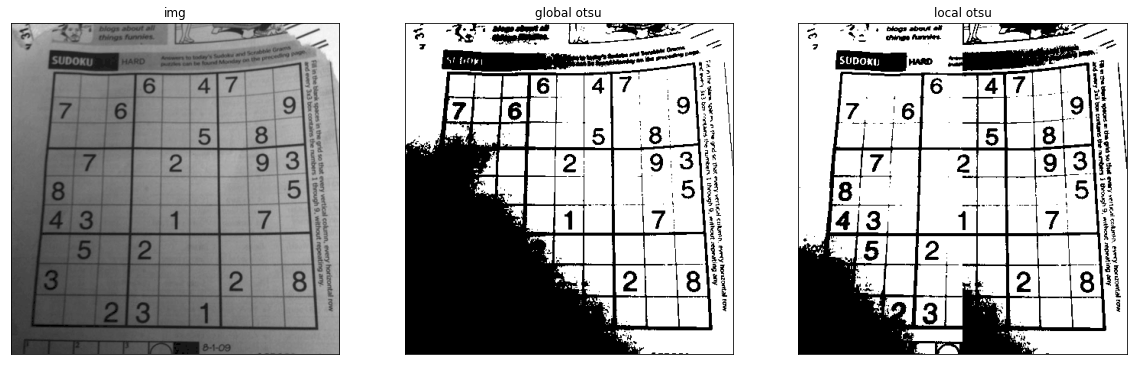

In [8]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])

plotter(image_list, 1, 3, True, 20, 10, '3B')

# PART 3C

Here is for your helper functions (optional).

Implement this function to get the adaptive threshold algorithm output.

In [9]:
def adaptive_th(image):
    '''
    Applys adaptive threshold on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.      :))))))))))))
    '''
    
    out_img = image.copy()
    
    #Write your code here
    out_img = cv2.adaptiveThreshold(image, 255, cv2.BORDER_REPLICATE, cv2.THRESH_BINARY, 15, 2)

    
    return out_img

Test your implementation (dont change this cell)

<ipython-input-5-95effa0f5ff2>:37: RuntimeWarning: invalid value encountered in long_scalars
  miu2 = np.sum(indexes[t:]*histogram[t:]) / w2
<ipython-input-5-95effa0f5ff2>:36: RuntimeWarning: invalid value encountered in long_scalars
  miu1 = np.sum(indexes[:t]*histogram[:t]) / w1


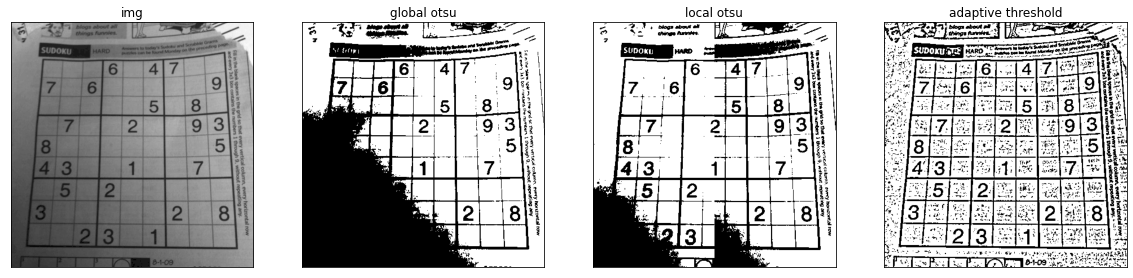

In [10]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])
image_list.append([adaptive_th(image), 'adaptive threshold', 'img'])

plotter(image_list, 1, 4, True, 20, 10, '3C')

# PART 4

Here is for your helper functions (optional).

In [11]:
def cornerHarris_demo(src, val):
    
#     Source : https://docs.opencv.org/3.4/d4/d7d/tutorial_harris_detector.html
    
    out = src.copy()
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    thresh = val
    
    # Detector parameters
    blockSize = 2
    apertureSize = 3
    k = 0.04
    
    # Detecting corners
    dst = cv2.cornerHarris(src_gray, blockSize, apertureSize, k)
    
    # Normalizing
    dst_norm = np.empty(dst.shape, dtype=np.float32)
    cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    dst_norm_scaled = cv2.convertScaleAbs(dst_norm)
    
    points = []
    # Drawing a circle around corners
    for i in range(dst_norm.shape[0]):
        for j in range(dst_norm.shape[1]):
            if int(dst_norm[i,j]) > thresh:
                cv2.circle(out, (j,i), 5, (255, 0, 0), 2)
                points.append((i, j))
                
    return out, points

Implement matching here.

In [12]:
def find_match(image1, image2):
    '''
    Finds match points between two input images.
    
    Parameters:
        image1 (numpy.ndarray): input image.
        image2 (numpy.ndarray): second input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    
    #Write your code here
    
    harris1, points1 = cornerHarris_demo(image1, 80)
    harris2, points2 = cornerHarris_demo(image2, 150)
    
    final_mapping = []
    mapping1 = []
    win_size = 2
    for point1 in points1:
        i1, j1 = point1
        window1 = image1[i1-win_size:i1+win_size, j1-win_size:j1+win_size]
        max_ = 0
        max_point2 = (0, 0)
        for point2 in points2:
            i2, j2 = point2
            window2 = image2[i2-win_size:i2+win_size, j2-win_size:j2+win_size]
            if window1.any() and window2.any():
                res = cv2.matchTemplate(window1, window2, cv2.TM_CCORR_NORMED)
                if res.max() > max_:
                    max_ = res.max()
                    max_point2 = point2
        mapping1.append((point1, max_point2))
        
    for point2 in points2:
        i2, j2 = point2
        window2 = image2[i2-win_size:i2+win_size, j2-win_size:j2+win_size]
        max_ = 0
        max_point1 = (0, 0)
        for point1 in points1:
            i1, j1 = point1
            window1 = image1[i1-win_size:i1+win_size, j1-win_size:j1+win_size]
            if window1.any() and window2.any():
                res = cv2.matchTemplate(window2, window1, cv2.TM_CCORR_NORMED)
                if res.max() > max_:
                    max_ = res.max()
                    max_point1 = point1
        if (max_point1, point2) in mapping1:
            final_mapping.append((max_point1, point2))

    result = np.concatenate((image1, image2), axis=1)
    
    for item in final_mapping:
        i1, j1 = item[0]
        i2, j2 = item[1]
        cv2.line(result, (j1,i1), (j2+image2.shape[1],i2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), 2)
      
    return result

Test your implementation (dont change this cell)

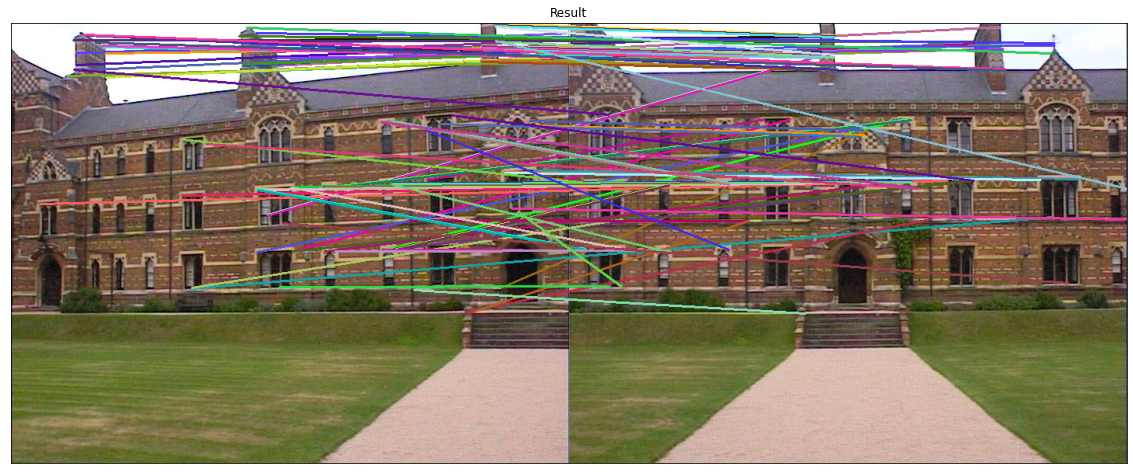

In [13]:
image_list = []

image1 = cv2.imread(os.path.join('images', 'building1.jpg'))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)


image2 = cv2.imread(os.path.join('images', 'building2.jpg'))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image_list.append([find_match(image1,image2), 'Result', 'img'])

plotter(image_list,1 , 1, True, 20, 10, '4')

for create proper files for sending in quera run this cell.

In [15]:
!python notebook_converter.py

End!!!